# Проект: телекоммуникации

### Описание проекта
- Цель: обучить модель для прогнозирования оттока клиентов оператора связи «ТелеДом». Благодоря модели сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Необходимо добиться, чтобы значение метрики Roc-Auc лучшей модели оказалось > 0.85. 

#### Описание данных
- contract_new.csv — информация о договоре:
    - customerID — идентификатор абонента;
    - BeginDate — дата начала действия договора;
    - EndDate — дата окончания действия договора;
    - Type — тип оплаты: раз в год-два или ежемесячно;
    - PaperlessBilling — электронный расчётный лист;
    - PaymentMethod — тип платежа;
    - MonthlyCharges — расходы за месяц;
    - TotalCharges — общие расходы абонента.
      
      
- personal_new.csv — персональные данные клиента:
    - customerID — идентификатор пользователя;
    - gender — пол;
    - SeniorCitizen — является ли абонент пенсионером;
    - Partner — есть ли у абонента супруг или супруга;
    - Dependents — есть ли у абонента дети.
    
    
- internet_new.csv — информация об интернет-услугах:
    - customerID — идентификатор пользователя;
    - InternetService — тип подключения;
    - OnlineSecurity — блокировка опасных сайтов;
    - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    - DeviceProtection — антивирус;
    - TechSupport — выделенная линия технической поддержки;
    - StreamingTV — стриминговое телевидение;
    - StreamingMovies — каталог фильмов.
    

- phone_new.csv — информация об услугах телефонии:
     - customerID — идентификатор пользователя;
     - MultipleLines — подключение телефона к нескольким линиям одновременно.
     
     
- Информация о договорах актуальна на 1 февраля 2020 года.

#### План работы
1. Загрузить и изучить данные;
2. Проверить на наличие недочетов и устраниить их;
3. Определить целевой признак;
4. Объеденить таблицы в одну;
5. Провести исследовательский анализ, отобрать данные наиболее хорошо отражающие различия между ушедшими и актуальными клиентами. Провести корреляционный анализ;
6. Подготовить данные для обучения моделей;
7. Определить наилучшую модель на метрике Roc-Auc;
8. Написать выводы о проделанной работе и дать рекомендации заказчику.

## Загрузка данных

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from warnings import simplefilter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## Предобработка данных

In [132]:
contract = pd.read_csv('/Users/admin/Documents/portfolio/vipusknoyprj/contract_new.csv', parse_dates=[1])
personal = pd.read_csv('/Users/admin/Documents/portfolio/vipusknoyprj/personal_new.csv')
internet = pd.read_csv('/Users/admin/Documents/portfolio/vipusknoyprj/internet_new.csv')
phone = pd.read_csv('/Users/admin/Documents/portfolio/vipusknoyprj/phone_new.csv')

### contract

In [133]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [134]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [135]:
contract['target'] = pd.Series
contract['target'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Формируем целевой признак, 1 - клиент ушёл, 0 - клиент - ещё клиент.

In [136]:
simplefilter(action='ignore', category=Warning)
contract['EndDate'][contract['EndDate'] == 'No'] = '2020-02-01'

In [137]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

Изменяем значения 'No' столбца EndDate на последнюю актуальную дату данных. И форматируем столбец

In [138]:
def na_duplicates(data):
    print(f'Кол-во дубликатов: {data.duplicated().sum()}, \nКол-во пропусков:\n{data.isna().sum()}')

In [139]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [140]:
# ищем скрытые дубликаты и ошибки
def name_err_func(data):
    for i in list(data.columns):
        if (type(data[i][0]) is str): print(i, data[i].unique())

In [141]:
def info_pro(data):
    display(data.head())
    print('\n')
    data.info()
    print('\n')
    na_duplicates(data)
    print('\n')
    name_err_func(data) 

In [142]:
info_pro(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


Кол-во дубликатов: 0, 
Кол-во пропусков:
customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharge

In [143]:
contract[contract['TotalCharges'].isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


Пропуски возникли из-за того, что дата начала контракта и крайняя дата актуальноси данных совпадают. Т.е. прошло меньше месяца с начала контракта.

In [144]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

In [145]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
dtype: int64

In [146]:
contract['day_at_all'] = contract['EndDate'] - contract['BeginDate']
contract['day_at_all'] = contract['day_at_all'].dt.days

In [147]:
contract['day_at_all_year'] = round(contract['day_at_all']/365)
contract['day_at_all_month'] = round(contract['day_at_all']/30)

In [148]:
contract['BeginDateYear'] = contract['BeginDate'].dt.year

### personal

In [149]:
info_pro(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Кол-во дубликатов: 0, 
Кол-во пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']


In [150]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace(0, 'No').replace(1, 'Yes')

### internet

In [151]:
info_pro(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Кол-во дубликатов: 0, 
Кол-во пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
InternetService ['DSL' 'Fiber optic']
OnlineSecurity ['No' '

In [152]:
internet['ServicesIsUsed'] = 'Yes'

### phone

In [153]:
info_pro(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Кол-во дубликатов: 0, 
Кол-во пропусков:
customerID       0
MultipleLines    0
dtype: int64


customerID ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
MultipleLines ['No' 'Yes']


Вывод: 
- В результате обработки 'contract' был произведен поиск дубликатов и пропусков, 
- Данные с пропусками в столбце TotalCharges (вида ' ') были удалены,
- Приведены к формату даты столбцы BeginDate и EndDate, 
- Приведен к правильному формату столбец TotalCharges. 
- Определили целевой признак - 'target'. 
- Создали признаки с разницами в днях, месяцах и годах между датами окончания и начала договора.
- Создали признак 'ServicesIsUsed', обозначающий, пользовался ли клиент доп. услугами.
- У остальных таблиц пропусков в данных и дубликатов не обнаружено.

## Объединение таблиц

In [154]:
contract.shape,personal.shape,internet.shape,phone.shape

((7043, 13), (7043, 5), (5517, 9), (6361, 2))

In [155]:
contract = contract.set_index('customerID')
personal = personal.set_index('customerID')
internet = internet.set_index('customerID')
phone = phone.set_index('customerID')

In [156]:
data_all = contract.merge(personal, how='left', left_index=True, right_index=True)
data_all = data_all.merge(internet, how='left', left_index=True, right_index=True)
data_all = data_all.merge(phone, how='left', left_index=True, right_index=True)

In [157]:
print(data_all.isna().sum())
print(data_all.shape[0])

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
day_at_all             0
day_at_all_year        0
day_at_all_month       0
BeginDateYear          0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
ServicesIsUsed      1526
MultipleLines        682
dtype: int64
7043


In [158]:
data_all = data_all.fillna('Not used')

In [159]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   target            7043 non-null   int64         
 8   day_at_all        7043 non-null   int64         
 9   day_at_all_year   7043 non-null   float64       
 10  day_at_all_month  7043 non-null   float64       
 11  BeginDateYear     7043 non-null   int32         
 12  gender            7043 non-null   object        
 13  SeniorCitizen     7043 non-null   object        
 14  Partner       

In [160]:
data_all.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,day_at_all,day_at_all_year,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,ServicesIsUsed,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,0.0,...,No,DSL,No,Yes,No,No,No,No,Yes,Not used
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,3.0,...,No,DSL,Yes,No,Yes,No,No,No,Yes,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,0.0,...,No,DSL,Yes,Yes,No,No,No,No,Yes,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,4.0,...,No,DSL,Yes,No,Yes,Yes,No,No,Yes,Not used
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,0.0,...,No,Fiber optic,No,No,No,No,No,No,Yes,No


После объединения таблиц заполнили получившиеся пропуски значением 'Not used'.

## Исследовательский анализ данных

### contract

In [161]:
def describe_pro(data, index):
    target='target'
    data_0 = data[data[target] == 0][index].value_counts(normalize=True) * 100
    data_1 = data[data[target] == 1][index].value_counts(normalize=True) * 100

    print('Распределение по категориям (%):')
    print('\nДоговор с клиентом актуален:')
    print(data_0.round(2), '\n')

    print('Клиент ушел:')
    print(data_1.round(2))

In [162]:
# функция для отображения гистограммы и ящика с усами для количественных признаков
def kol_graf(data, index, target='target', xlabel=None, ylabel=None, title=None):
    data_0 = data[data[target] == 0][index]
    data_1 = data[data[target] == 1][index]
    
    print('Договор с клиентом актуален:\n', data_0.describe())
    print('\nКлиент ушел:\n', data_1.describe())
    
    plt.figure(figsize=(8, 5))
    plt.hist(data_0, bins=50, alpha=0.5, label='Договор с клиентом актуален', color='blue')
    plt.hist(data_1, bins=50, alpha=0.5, label='Клиент ушел', color='purple')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(5,5), dpi= 80)
    plt.boxplot(data[index])
    plt.ylabel(xlabel);

Распределение по категориям (%):

Договор с клиентом актуален:
Type
Month-to-month    58.36
Two year          22.11
One year          19.52
Name: proportion, dtype: float64 

Клиент ушел:
Type
Month-to-month    36.97
Two year          34.60
One year          28.43
Name: proportion, dtype: float64


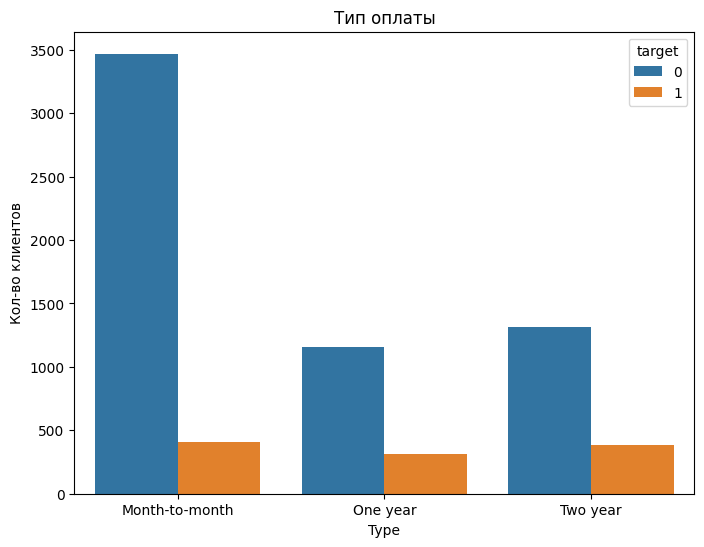

In [163]:
describe_pro(contract, 'Type')
plt.figure(figsize=(8, 6))
sns.countplot(data=contract, x='Type', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Тип оплаты')
plt.show();

Распределение по категориям (%):

Договор с клиентом актуален:
PaperlessBilling
Yes    58.06
No     41.94
Name: proportion, dtype: float64 

Клиент ушел:
PaperlessBilling
Yes    65.49
No     34.51
Name: proportion, dtype: float64


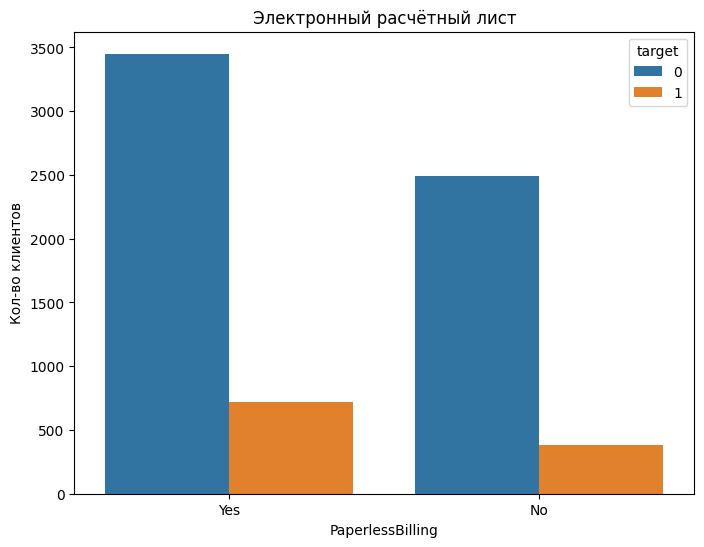

In [164]:
describe_pro(contract, 'PaperlessBilling')
plt.figure(figsize=(8, 6))
sns.countplot(data=contract, x='PaperlessBilling', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Электронный расчётный лист')
plt.show();

Распределение по категориям (%):

Договор с клиентом актуален:
PaymentMethod
Electronic check             33.91
Mailed check                 25.16
Bank transfer (automatic)    20.65
Credit card (automatic)      20.28
Name: proportion, dtype: float64 

Клиент ушел:
PaymentMethod
Electronic check             31.79
Bank transfer (automatic)    28.79
Credit card (automatic)      28.79
Mailed check                 10.63
Name: proportion, dtype: float64


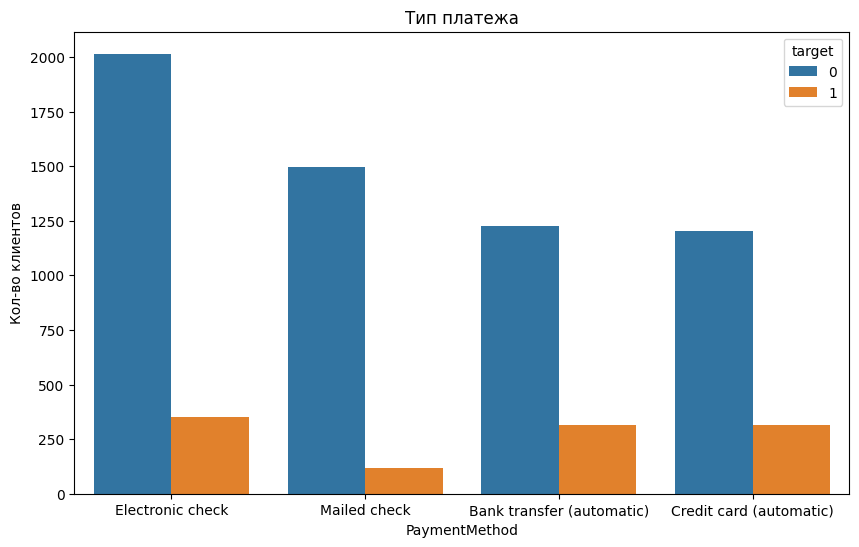

In [165]:
describe_pro(contract, 'PaymentMethod')
plt.figure(figsize=(10, 6))
sns.countplot(data=contract, x='PaymentMethod', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Тип платежа')
plt.show();

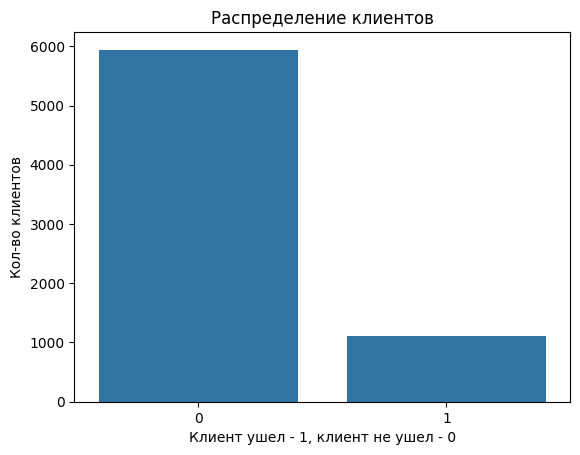

In [166]:
sns.countplot(data=contract, x='target')
plt.xlabel('Клиент ушел - 1, клиент не ушел - 0')
plt.ylabel('Кол-во клиентов')
plt.title('Распределение клиентов');

Договор с клиентом актуален:
 count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: MonthlyCharges, dtype: float64

Клиент ушел:
 count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: MonthlyCharges, dtype: float64


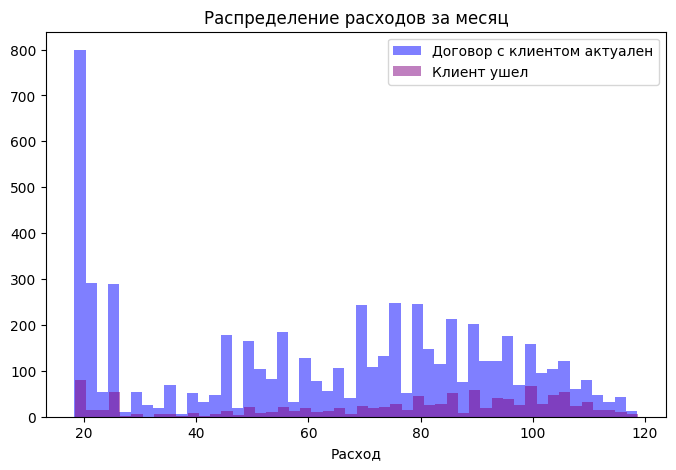

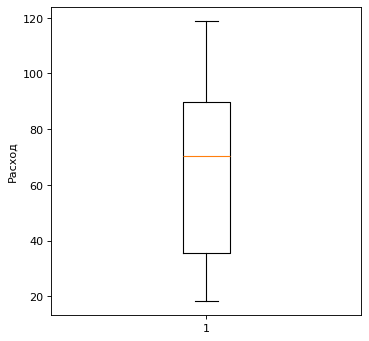

In [167]:
kol_graf(contract, 'MonthlyCharges', xlabel='Расход', \
         title='Распределение расходов за месяц')

Договор с клиентом актуален:
 count    5942.000000
mean     2067.943095
std      2193.827140
min        19.050000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: TotalCharges, dtype: float64

Клиент ушел:
 count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: TotalCharges, dtype: float64


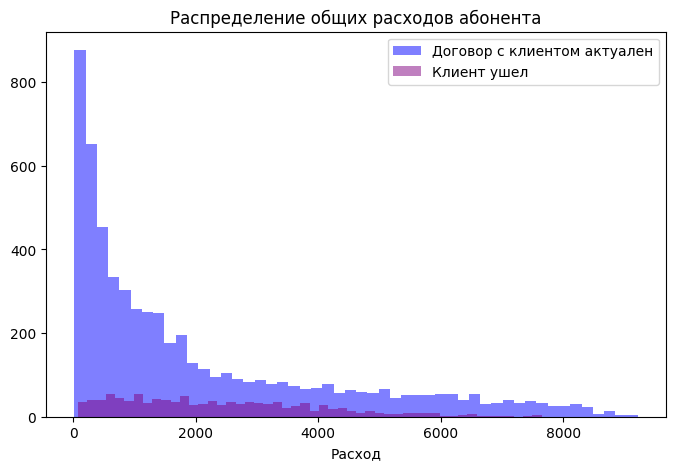

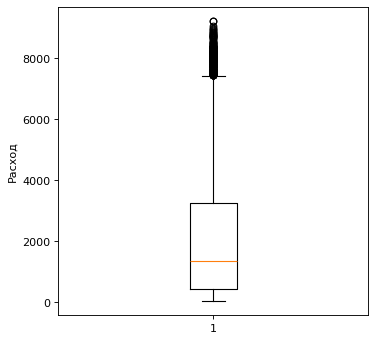

In [168]:
kol_graf(contract, 'TotalCharges', xlabel='Расход', \
         title='Распределение общих расходов абонента')

Договор с клиентом актуален:
 count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: day_at_all, dtype: float64

Клиент ушел:
 count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: day_at_all, dtype: float64


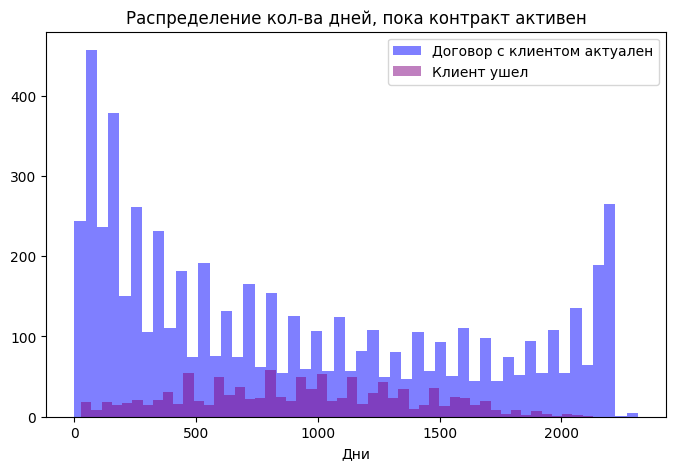

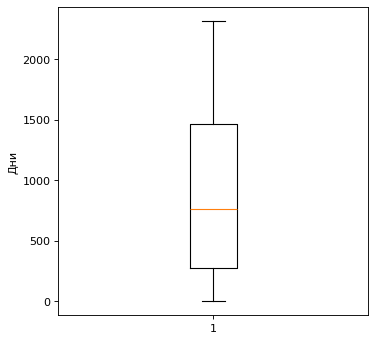

In [169]:
kol_graf(contract, 'day_at_all', xlabel='Дни', \
         title='Распределение кол-ва дней, пока контракт активен')

### personal

Распределение по категориям (%):

Договор с клиентом актуален:
gender
Male      50.19
Female    49.81
Name: proportion, dtype: float64 

Клиент ушел:
gender
Male      52.04
Female    47.96
Name: proportion, dtype: float64


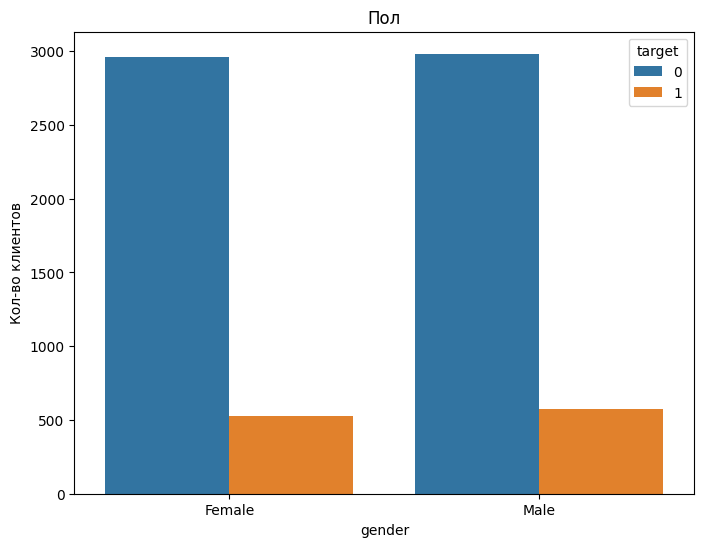

In [170]:
describe_pro(data_all, 'gender')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='gender', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Пол')
plt.show();

Распределение по категориям (%):

Договор с клиентом актуален:
SeniorCitizen
No     84.69
Yes    15.31
Name: proportion, dtype: float64 

Клиент ушел:
SeniorCitizen
No     78.93
Yes    21.07
Name: proportion, dtype: float64


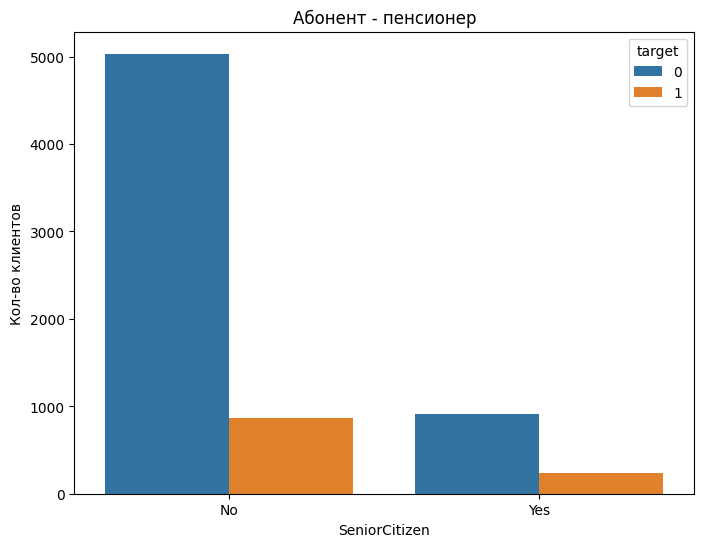

In [171]:
describe_pro(data_all, 'SeniorCitizen')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='SeniorCitizen', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Абонент - пенсионер')
plt.show();

Распределение по категориям (%):

Договор с клиентом актуален:
Partner
No     54.85
Yes    45.15
Name: proportion, dtype: float64 

Клиент ушел:
Partner
Yes    65.3
No     34.7
Name: proportion, dtype: float64


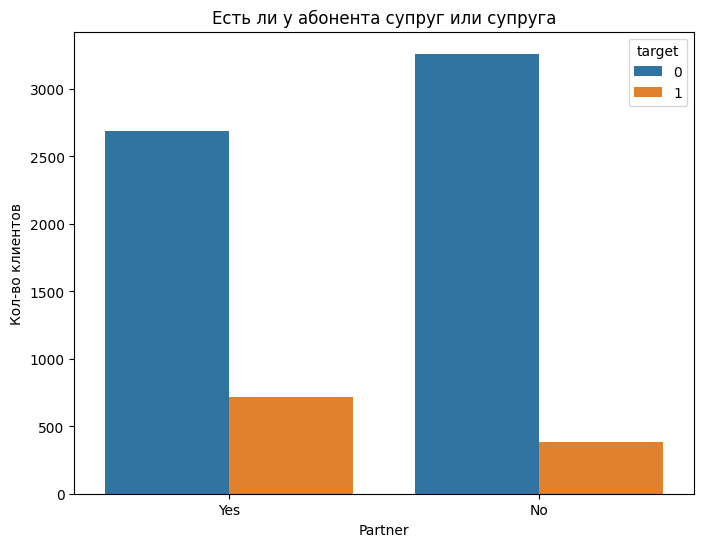

In [172]:
describe_pro(data_all, 'Partner')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='Partner', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Есть ли у абонента супруг или супруга')
plt.show();

Распределение по категориям (%):

Договор с клиентом актуален:
Dependents
No     70.68
Yes    29.32
Name: proportion, dtype: float64 

Клиент ушел:
Dependents
No     66.58
Yes    33.42
Name: proportion, dtype: float64


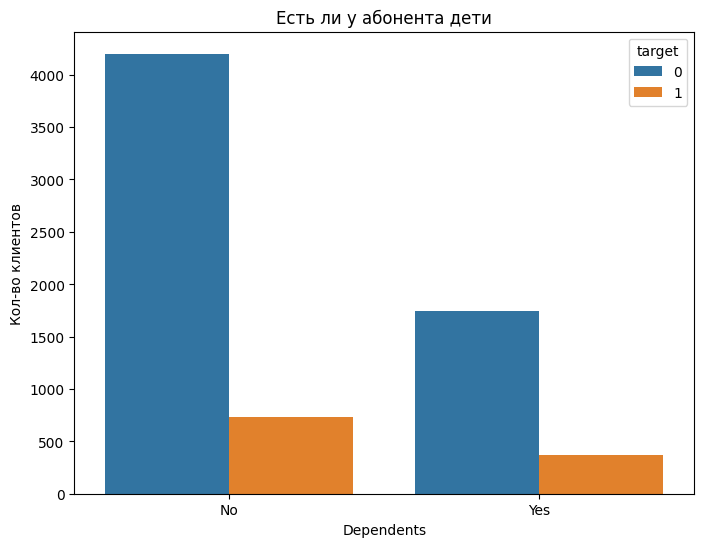

In [173]:
describe_pro(data_all, 'Dependents')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='Dependents', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Есть ли у абонента дети')
plt.show();

### internet

Распределение по категориям (%):

Договор с клиентом актуален:
ServicesIsUsed
Yes         77.01
Not used    22.99
Name: proportion, dtype: float64 

Клиент ушел:
ServicesIsUsed
Yes         85.47
Not used    14.53
Name: proportion, dtype: float64


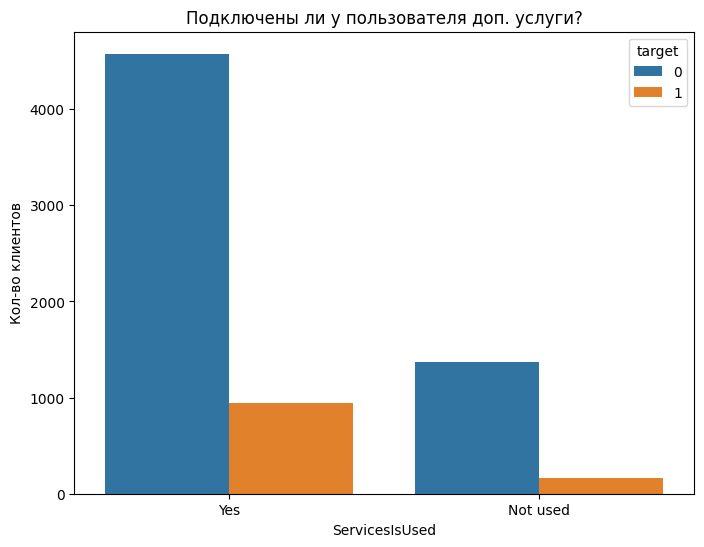

In [174]:
describe_pro(data_all, 'ServicesIsUsed')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='ServicesIsUsed', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Подключены ли у пользователя доп. услуги?')
plt.show();

### phone

Распределение по категориям (%):

Договор с клиентом актуален:
MultipleLines
No          51.67
Yes         38.59
Not used     9.74
Name: proportion, dtype: float64 

Клиент ушел:
MultipleLines
Yes         61.58
No          29.06
Not used     9.36
Name: proportion, dtype: float64


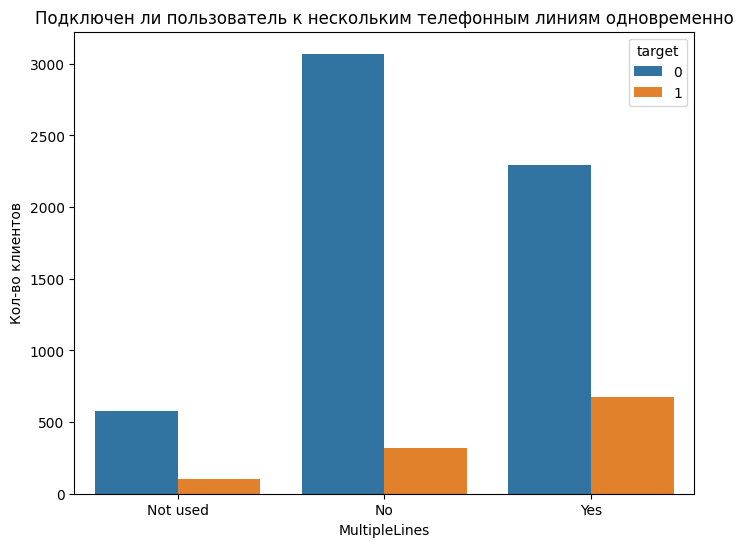

In [175]:
describe_pro(data_all, 'MultipleLines')
plt.figure(figsize=(8, 6))
sns.countplot(data=data_all, x='MultipleLines', hue='target')
plt.ylabel('Кол-во клиентов')
plt.title('Подключен ли пользователь к нескольким телефонным линиям одновременно')
plt.show();

### Корреляционный анализ

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'day_at_all', 'day_at_all_year', 'day_at_all_month', 'BeginDateYear']


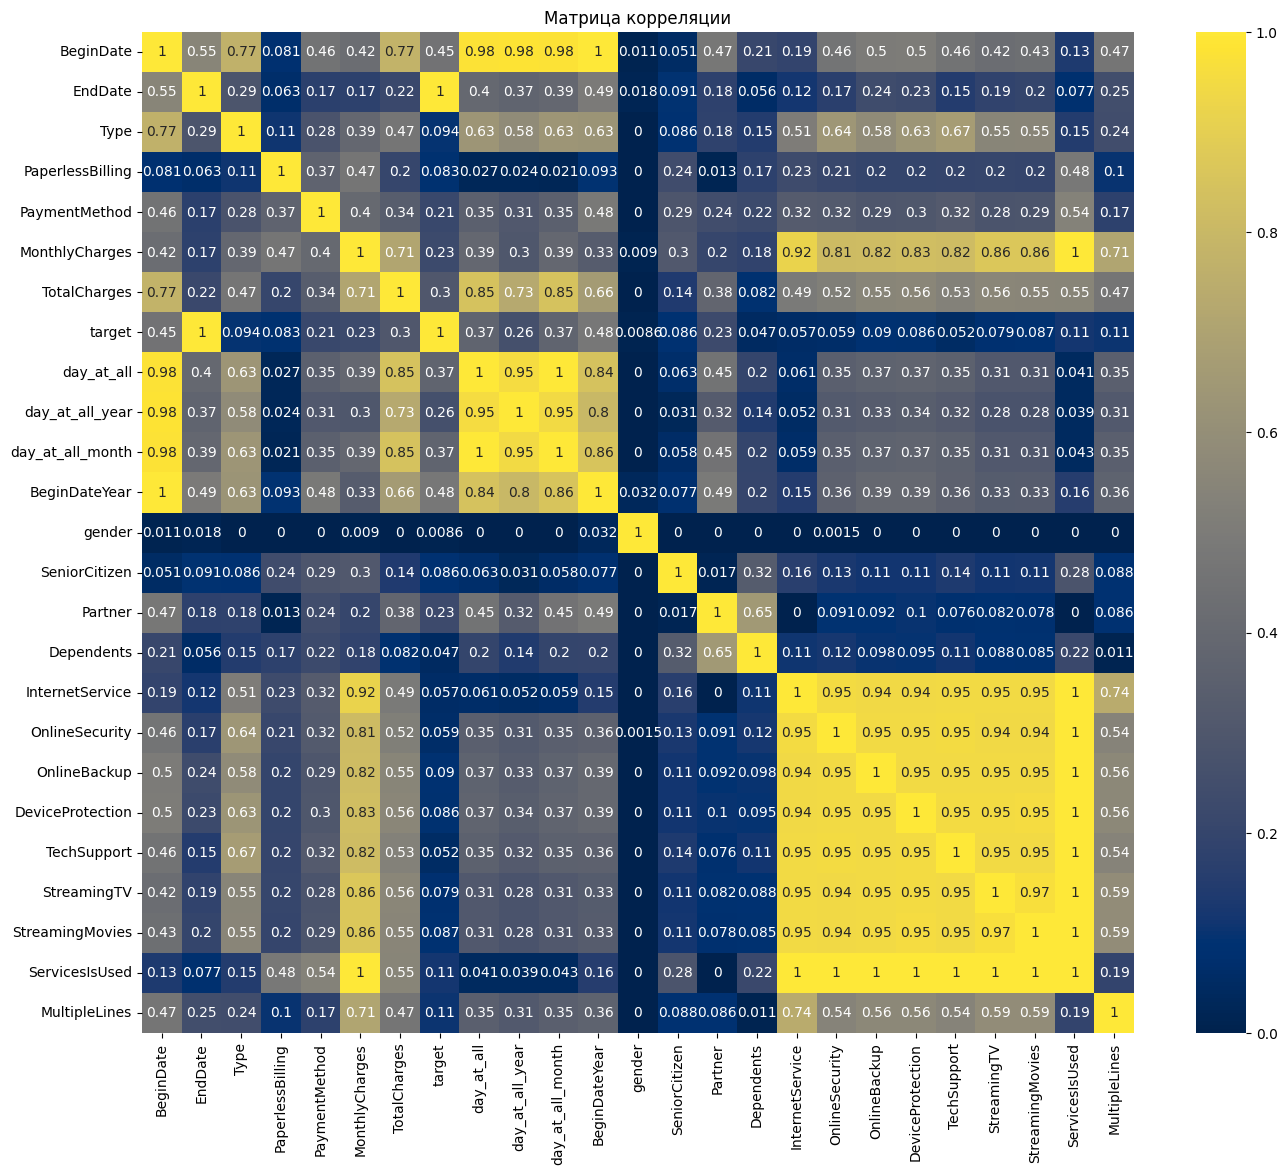

In [176]:
plt.figure(figsize = (16,13))

sns.heatmap(data_all.phik_matrix(), annot=True, cmap='cividis')
plt.title('Матрица корреляции');

Вывод: 
- Наблюдая за распределениями расходов за месяц и общими расходами видно, что средние и медианные расходы - выше у ушедших клиентов, особенно отличаются медианные значения. 
- Видно, что доля клиентов с небольшим (0 - 250 дней) и большим (> 2000 дней) сроками контракта больше среди актуальных, чем у ушедших. 
- Большая часть клиентов имеет помесячный тип оплаты (58%), в то время как ушедшие клиенты примерно равной степени используют все типы оплаты. 
- Среди ушедших клиентов доля людей в браке выше. 
- Так же ушедшие пользователи чаще подключали доп. услуги. 
- Сильного различия в поведении клиентов у остальных признаков не наблюдается.

## Подготовка данных

Для обучения моделей возьмём данные, в которых видно различие в поведении разных групп пользователей и коррелирующих с целевым признаком.

Использование созданных признаков 'day_at_all_year', 'day_at_all_month' не влияет на обучение модели, при использовании 'BeginDateYear' (содержит год начала контракта) - модели переобучаются.

In [177]:
RANDOM_STATE = 50525
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data_all.drop('target', axis=1),
    data_all['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

ohe_columns = ['MultipleLines', 'ServicesIsUsed', 'Partner', 'PaymentMethod', 'Type']
num_columns = ['MonthlyCharges', 'TotalCharges', 'day_at_all']

In [178]:
encoder =  OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns]) 
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names_out()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

In [179]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_all = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_all = pd.concat([X_test_ohe, X_test_scaled], axis=1)

## Обучение и сравнение моделей

### LogisticRegression

In [180]:
model_log = LogisticRegression()
params = {'n_jobs':(-1, 1)}

In [181]:
randomized_search_log = RandomizedSearchCV(
    model_log, 
    params, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_log.fit(X_train_all, y_train);

In [182]:
test_score_log = randomized_search_log.best_score_

In [183]:
print('Лучшие параметры модели:', randomized_search_log.best_params_)
print(f'Метрика Roc-Auc на кросс-валидации: {round(test_score_log, 2)}')

Лучшие параметры модели: {'n_jobs': -1}
Метрика Roc-Auc на кросс-валидации: 0.76


### CatBoost

In [184]:
model_cat = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)
params = {'depth': (2, 4, 6, 8),
          'iterations':(250, 500, 375, 750, 1000),
          'learning_rate':(0.1, 0.175, 0.25, 0.375, 0.5)}

In [185]:
randomized_search_cat = RandomizedSearchCV(
    model_cat, 
    params, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_cat.fit(X_train_all, y_train);

In [186]:
test_score_cat = randomized_search_cat.best_score_

In [187]:
print('Лучшие параметры модели:', randomized_search_cat.best_params_)
print(f'Метрика Roc-Auc на кросс-валидации: {round(test_score_cat,2)}')

Лучшие параметры модели: {'learning_rate': 0.375, 'iterations': 250, 'depth': 4}
Метрика Roc-Auc на кросс-валидации: 0.92


### RandomForest

In [188]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, verbose=0, class_weight='balanced')
params = {'max_depth': (2, 3, 4),
          'n_estimators': (100, 175, 250, 375, 500, 750, 1000),
          'min_samples_leaf': (2, 3, 4),
          'min_samples_split': (2, 3, 4)}

In [189]:
randomized_search_forest = RandomizedSearchCV(
    model_forest, 
    params, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_forest.fit(X_train_all, y_train);

In [190]:
test_score_forest = randomized_search_forest.best_score_

In [191]:
print('Лучшие параметры модели:', randomized_search_forest.best_params_)
print(f'Метрика Roc-Auc на кросс-валидации: {round(test_score_forest, 2)}')

Лучшие параметры модели: {'n_estimators': 375, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}
Метрика Roc-Auc на кросс-валидации: 0.81


## Результаты

In [192]:
y_pred = randomized_search_cat.best_estimator_.predict_proba(X_test_all)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print('Метрика Roc-Auc лучшей модели - CatBoost на тестовых данных:', \
      round(auc,2))

Метрика Roc-Auc лучшей модели - CatBoost на тестовых данных: 0.93


In [193]:
acc = accuracy_score(y_test, randomized_search_cat.best_estimator_.predict(X_test_all))
print('Метрика Accuracy лучшей модели - CatBoost на тестовых данных:', \
      round(acc,2))

Метрика Accuracy лучшей модели - CatBoost на тестовых данных: 0.94


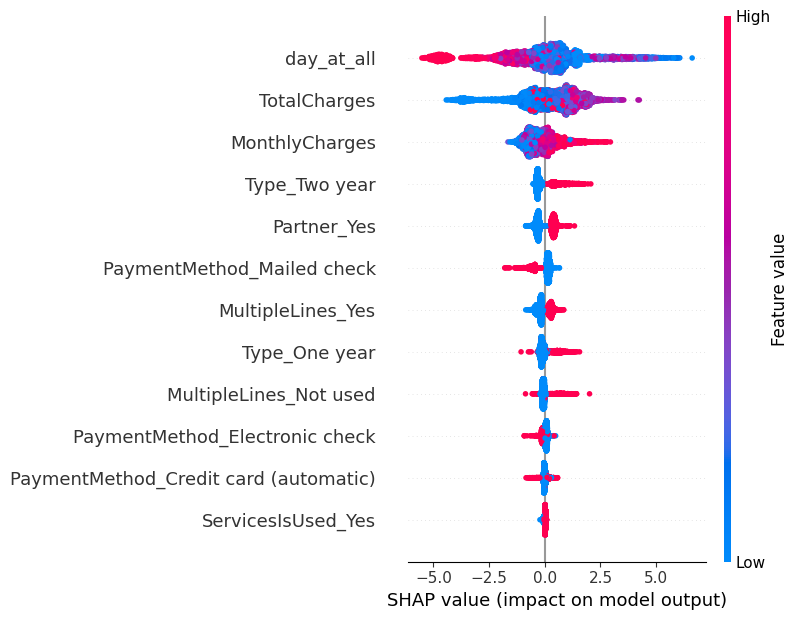

In [194]:
best_model = randomized_search_cat.best_estimator_
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_all)

shap.summary_plot(shap_values, X_train_all)

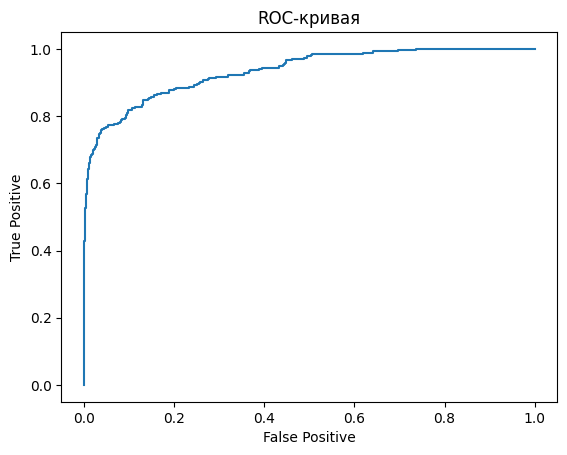

In [195]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred)

plt.title('ROC-кривая')
plt.plot(fpr, tpr)
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()

In [196]:
# подбираем оптимальный порог для классификации
score = tpr - fpr
best_threshold = thresholds[score.argmax()]
best_threshold

0.2745666198650943

In [223]:
y_pred_matrix = (y_pred >= best_threshold).astype(int)

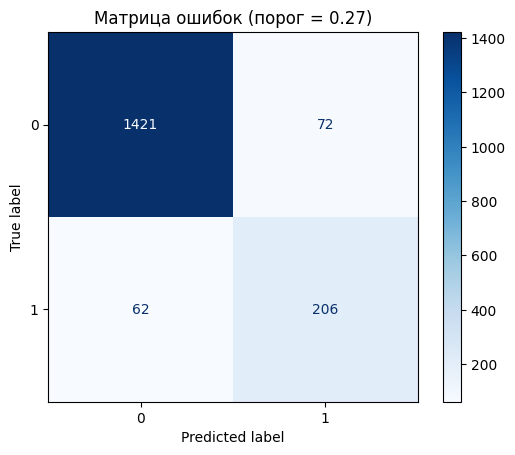

In [225]:
cm = confusion_matrix(y_test, y_pred_matrix)

disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title(f"Матрица ошибок (порог = {best_threshold:.2f})")
plt.show()

Можно сделать вывод о том, что модель лучше всего справляется с предсказанием класса 0, т.е. то, что клиент останется. При этом чаще всего ошибается предсказывая отток клиентов, в реальности не уходящих.

## Выводы

1. Данные были изучены и предобработаны;
2. Был определен целевой признак;
3. В процессе анализа данных создали новые признаки из имеющихся;
4. Визуализировали распределения признаков;
5. Отобрали наиболее значимые признаки, разбили данные на тренировочные и тестовые. Подготовили данные для обучения на них моделей;
6. Обучили три модели: LogisticRegression, CatBoost и RandomForest. Определили лучшую модель - CatBoost с метрикой Roc-Auc на кросс-валидации: 0.92;
7. Произвели предсказания на тестовых данных с помощью лучшей модели и получили значение метрик Roc-Auc: 0.93 и accuracy: 0.94. Интерпретировали важность признаков.

Рекомендации для заказчика: так как наиболее важными для модели оказались признаки, отвечающие за: длительность контракта, расходы абонентов (меньшие расходы = большая вероятность оттока), тип срока контракта (клиенты с контрактами > года остаются, а с контрактами с помесячной оплатой склонны к оттоку) и на их семейное положение, то большее внимание следует уделить именно им. Нужно стремиться к тому, чтобы пользователи чаще выбирали контракт сроком на два года.